In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import time
import cv2
%matplotlib notebook

In [9]:
plot = True

In [14]:
path = 'kalibracija/f105'
path = 'miza'
filetypes = ['png', 'tiff', 'jpg']

pattern_size = (6, 4)
d_pattern = (40, 40)
RATIO = 0.25

In [15]:
slike = []
for filetype in filetypes:
    slike += glob.glob(os.path.join(path, '*.{:s}'.format(filetype)))
npy = glob.glob(os.path.join(path, '*.npy'))

#### Priprava slik

In [16]:
if 'grayscale.npy' in [_.split('\\')[-1] for _ in npy]:
    grayscale = np.load(os.path.join(path, 'grayscale.npy'))
else:    
    grayscale = []
    for i, slika in enumerate(slike):
        filetype = slika.split('.')[-1]
        if filetype.lower() in filetypes:
            im = plt.imread(slika)
            if im.ndim == 2:
                grayscale.append(im)
            elif im.ndim == 3:
                bw = cv2.cvtColor(np.uint8(im), cv2.COLOR_BGR2GRAY)
                grayscale.append(np.uint8(bw))
        print(f'{i+1}/{len(slike)}', end='\r')
    np.save(os.path.join(path, 'grayscale.npy'), np.array(grayscale))

<IPython.core.display.Javascript object>


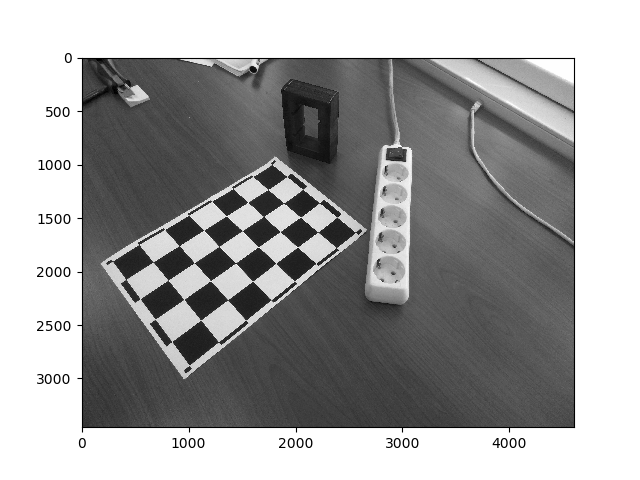

In [17]:
if plot:
    sequence = grayscale
    fig = plt.figure()
    im = plt.imshow(sequence[0], cmap='gray', interpolation='nearest', animated=True) # starting image

    def updatefig(i):
        im.set_array(sequence[i])
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames=len(sequence), interval=200, blit=False)
    plt.show()

In [20]:
def calibrate_camera(views, pattern_size, d_pattern):
    """
    Given the images of a calibration pattern of specified 
    dimensions and block size find the camera calibration matrix
    """
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    object_points = []
    image_points = []
    object_p = np.zeros((pattern_size[0] * pattern_size[1], 3), dtype=np.float32)
    object_p[:,:2] = np.mgrid[0:pattern_size[0]*d_pattern[0]:d_pattern[0], 
                              0:pattern_size[1]*d_pattern[1]:d_pattern[1]].T.reshape(-1,2)

    for i, im in enumerate(views):
        img = cv2.resize(im, dsize=(0, 0), fx=RATIO, fy=RATIO)
        found, corners = cv2.findChessboardCorners(img, pattern_size, cv2.CALIB_CB_ADAPTIVE_THRESH)
        if found:
            image_points.append(cv2.cornerSubPix(img, corners,(5,5), (-1,-1), criteria))
            object_points.append(object_p)
            
    scaled_im_points = np.array(image_points) / RATIO
    scaled_im_shape = tuple((np.array(img.shape) / RATIO).astype(int))[::-1]
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(np.array(object_points), scaled_im_points, scaled_im_shape, None, None)
    return(K)

In [21]:
K = calibrate_camera(grayscale, pattern_size, d_pattern)
K

array([[  3.76075306e+03,   0.00000000e+00,   2.37607884e+03],
       [  0.00000000e+00,   3.74738075e+03,   1.52512065e+03],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [9]:
g1 = np.load(glob.glob('kalibracija/f24/*.npy')[0])
g2 = np.load(glob.glob('kalibracija/f105/*.npy')[0])

In [10]:
K1 = calibrate_camera(g1, pattern_size, d_pattern)
K2 = calibrate_camera(g2, pattern_size, d_pattern)

In [11]:
K1

array([[  4.44790961e+03,   0.00000000e+00,   2.29016028e+03],
       [  0.00000000e+00,   4.46505469e+03,   1.48471177e+03],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [12]:
K2

array([[  1.95777085e+04,   0.00000000e+00,   3.52471640e+03],
       [  0.00000000e+00,   1.94938922e+04,   1.67752625e+03],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [13]:
f1 = np.mean(np.diag(K1[:2]))
f2 = np.mean(np.diag(K2[:2]))

In [14]:
f2/f1

4.3836819484708194

In [15]:
105/24

4.375